# Тема: «Использование инструментов АОТ для выделения характеристик персонажей из текстов художественной литературы (на материале романа Джона Рональда Руэла Толкина «Властелин Колец»).


### Часть 1. Парсинг текста романа

In [61]:
#импорты
!pip install beautifulsoup4
!pip install fake_useragent
import requests as rq
from bs4 import BeautifulSoup
import pandas as pd
import time
from fake_useragent import UserAgent
ua = UserAgent(browsers=['firefox', 'chrome'])
ua.random
import re

In [62]:
#с этого сайта будем парсить Властелина Колец, проверим его
url = 'https://libking.ru/books/sf-/sf-heroic/1083967-dzhon-tolkin-vlastelin-kolec-litres.html#book'
page = rq.get(url)

print(page.status_code) #проверяем код ответа

200


In [63]:
soup = BeautifulSoup(page.text, features="html.parser")
print(soup.prettify()) #найдем, где спрятан текст и ссылки на остальные страницы

<!DOCTYPE html>
<html lang="ru" prefix="og: http://ogp.me/ns#" xml:lang="ru" xmlns="http://www.w3.org/1999/xhtml">
 <head>
  <meta content="initial-scale=1.0, width=device-width" name="viewport"/>
  <meta content="Читать онлайн" property="og:site_name"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <title>
   Джон Толкин - Властелин Колец litres читать онлайн бесплатно
  </title>
  <meta content="Джон Толкин Властелин Колец litres читать онлайн бесплатно и без регистрации полностью (целиком) на пк и телефоне. Краткое содержание и отзывы о книге на LibKing.Ru" name="description"/>
  <meta content="Джон Толкин Властелин Колец litres читать онлайн, Властелин Колец litres книга, читать Властелин Колец litres онлайн бесплатно" name="keywords"/>
  <meta content="LibKing.Ru" property="og:description"/>
  <meta content="https://libking.ru/uploads/posts/new_books3/dzhon-tolkin-vlastelin-kolec-litres.jpg" property="og:image"/>
  <meta content="https://libking.ru/uploa


*Нас интересует текст с 3 по 416 страницы. (Только основной текст, без приложений. Также нам не нужны примечания и глоссарий, которые составляют значительный массив текста в конце книги)
Видим, что ссылки не прописаны на все страницы, поэтому переберем их range-м*

In [64]:
#делаем цикл и собираем по кусочкам ссылки
j = 'https://libking.ru/books/sf-/sf-heroic/1083967-'
k = '-dzhon-tolkin-vlastelin-kolec-litres.html#book'
book_links = []
for i in range(3, 417):
  book_links.append(j + str(i) + k)
print(book_links)

['https://libking.ru/books/sf-/sf-heroic/1083967-3-dzhon-tolkin-vlastelin-kolec-litres.html#book', 'https://libking.ru/books/sf-/sf-heroic/1083967-4-dzhon-tolkin-vlastelin-kolec-litres.html#book', 'https://libking.ru/books/sf-/sf-heroic/1083967-5-dzhon-tolkin-vlastelin-kolec-litres.html#book', 'https://libking.ru/books/sf-/sf-heroic/1083967-6-dzhon-tolkin-vlastelin-kolec-litres.html#book', 'https://libking.ru/books/sf-/sf-heroic/1083967-7-dzhon-tolkin-vlastelin-kolec-litres.html#book', 'https://libking.ru/books/sf-/sf-heroic/1083967-8-dzhon-tolkin-vlastelin-kolec-litres.html#book', 'https://libking.ru/books/sf-/sf-heroic/1083967-9-dzhon-tolkin-vlastelin-kolec-litres.html#book', 'https://libking.ru/books/sf-/sf-heroic/1083967-10-dzhon-tolkin-vlastelin-kolec-litres.html#book', 'https://libking.ru/books/sf-/sf-heroic/1083967-11-dzhon-tolkin-vlastelin-kolec-litres.html#book', 'https://libking.ru/books/sf-/sf-heroic/1083967-12-dzhon-tolkin-vlastelin-kolec-litres.html#book', 'https://libking

In [65]:
#теперь нам нужно спарсить все по каждой ссылке - 7 мин.
book_soup = []
for links in book_links:
  pages = rq.get(links)
  book_soup.append(BeautifulSoup(pages.text, features="html.parser"))
print(book_soup[0-10])

<!DOCTYPE html>

<html lang="ru" prefix="og: http://ogp.me/ns#" xml:lang="ru" xmlns="http://www.w3.org/1999/xhtml">
<head>
<meta content="initial-scale=1.0, width=device-width" name="viewport"/>
<meta content="Читать онлайн" property="og:site_name"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<title>Джон Толкин - Властелин Колец litres читать онлайн бесплатно</title>
<meta content="Джон Толкин Властелин Колец litres читать онлайн бесплатно и без регистрации полностью (целиком) на пк и телефоне. Краткое содержание и отзывы о книге на LibKing.Ru" name="description"/>
<meta content="Джон Толкин Властелин Колец litres читать онлайн, Властелин Колец litres книга, читать Властелин Колец litres онлайн бесплатно" name="keywords"/>
<meta content="LibKing.Ru" property="og:description"/>
<meta content="https://libking.ru/uploads/posts/new_books3/dzhon-tolkin-vlastelin-kolec-litres.jpg" property="og:image"/>
<meta content="https://libking.ru/uploads/posts/new_books3/dzhon

In [ ]:
# и выбрать весь текст
raw = []
for raw_text in book_soup:
  raw_text.find_all('p')
  raw.append(raw_text.text)
raw


В спарсенном тексте видим несколько бросающихся в глаза проблем:


1.   Повторяющиеся на каждой странице последовательности
2.   Некоторые слова склеились с числами, нужно их расклеить, удалив числа.
4.   Нужно также убрать кусочек текста в конце, оставшийся на последней странице от "Приложений".





In [ ]:
#почистим видимые недочеты в строках
clean = []
for each_line in raw:
  clean.append(each_line.replace('\n','').replace('Читать дальше','').replace('...','').replace('\xa0','').replace('\t','').replace('Джон Толкин - Властелин Колец [litres]','').replace('СветШрифт:↓↑GeorgiaGeorgiaTahomaArialVerdanaSymbolСброситьИнтервал:↓↑Закладка:Сделать','').replace('Похожие книги на "Властелин Колец [litres]", Джон Толкин','').replace('Книги похожие на "Властелин Колец [litres]" читать онлайн бесплатно полные версии.','').replace('Джон Фланаган - Волшебник СевераДжон Фланаган - Осада МакиндоДжон Фланаган - Битва за СкандиюДжон Фланаган - Ледяная земляЛлойд Александер - Книга Трех [litres]Джон Толкин - Хоббит [litres]Эдгар Берроуз - Джон Картер. Книги 1-12Джон Толкин - Сильмариллион [litres] Джон Толкин читать все книги автора по порядкуДжон ТолкинДжон Толкин - все книги автора в одном месте читать по порядку полные версии на сайте онлайн библиотеки LibKing.Властелин Колец [litres] отзывы Отзывы читателей о книге Властелин Колец [litres], автор: Джон Толкин.','').replace('Читайте комментарии и мнения людей о произведении.Понравилась книга? Поделитесь впечатлениями - оставьте Ваш отзыв или расскажите друзьям','').replace('Прокомментировать','').replace('Отправить отзыв','').replace('Нина7 ноября 2023 19:59Потрясающие книги Джон Толкин мгновенно завоевал мою душу, люди читайте эти  книги трилогия Властелин Колец шикарный, я скучаю по фильмам жаль что их не показывают по телевизору, в Новый год это просто лучшее кино!!!!','').replace('Любовные романыФантастика и фэнтезиПриключенияДетективы и триллерыНаука, ОбразованиеДокументальныеПрозаДетская литератураДом и семьяБизнесРелигия и духовностьСправочная литератураСтаринная литератураЮморКомпьютеры и ИнтернетПоэзия, ДраматургияДетективы и триллерыБоевикДетективИроническиеИсторическиеКлассическиеКрутыеТриллерыШпионскиеФантастика и фэнтезиБоеваяГероическаяДетективнаяКосмическаяНаучнаяПсихологическаяУжасы и МистикаФэнтезиЭпическаяЛюбовные романыИсторическиеКороткиеФантастическиеОстросюжетныеСовременныеЭротическиеИнформацияПравообладателямПолитика конфиденциальностиОбратная связь','').replace('Большинство книг на сайте опубликовано легально на правах партнёрской программы ЛитРес. Если Ваша книга была опубликована с нарушениями авторских прав, пожалуйста, направьте Вашу жалобу на PGEgaHJlZj0ibWFpbHRvOmFidXNlQGxpYmtpbmcucnUiIHJlbD0ibm9mb2xsb3ciPmFidXNlQGxpYmtpbmcucnU8L2E+ или заполните форму обратной связи.','').replace('Войти на сайтЧужой компьютерЗабыли пароль?Регистрация','').replace('Джон Толкин - Властелин Колец litres читать онлайн бесплатноLibKing.RuОКLibKing » Книги » Фантастика и фэнтези » Героическая фантастика »','').replace('Тут можно читать онлайн  - бесплатно полную версию книги (целиком). Жанр: Героическая фантастика, издательство Литагент АСТ, год 2016.','').replace('Здесь Вы можете читать  полную версию (весь текст) онлайн без регистрации и SMS на сайте LibKing.Ru (ЛибКинг) или прочесть краткое содержание, предисловие (аннотацию), описание и ознакомиться с отзывами (комментариями) о произведении.','').replace('Название: Властелин Колец [litres]Автор: Джон ТолкинЖанр: Героическая фантастикаИздательство: Литагент АСТГод: 2016ISBN: 978-5-17-092791-3Рейтинг:3.86/5. Голосов:','').replace('301Избранное: Добавить в избранноеОтзывы: Читать комментарии (1) Ваша оценка:8012345 краткое содержание','').replace('Властелин Колец [litres] - описание и краткое содержание, автор Джон Толкин, читайте бесплатно онлайн на сайте электронной библиотеки LibKing.Ru','').replace('Джон Рональд Руэл Толкин (3.01.1892–2.09.1973) – писатель, поэт, филолог, профессор Оксфордского университета, родоначальник современной фэнтези. В 1937 году был написан «Хоббит», а в середине 1950-х годов увидели свет три книги «Властелина колец», повествующие о Средиземье – мире, населенном представителями волшебных рас со сложной культурой, историей и мифологией.','').replace('Существует свыше десятка переводов трилогии на русский язык. В данное издание вошел перевод В. Каррика, М. Каменкович.','').replace('Властелин Колец [litres] - читать онлайн бесплатно полную версию (весь текст целиком)','').replace('Властелин Колец [litres] - читать книгу онлайн бесплатно, автор Джон Толкин','').replace('Приложения678Приложение АЛЕТОПИСИ КОРОЛЕЙ И ВЛАСТИТЕЛЕЙОб источниках большей части материала, содержащегося в приводимом ниже тексте, особенно в Приложениях А и Г, говорится в книге первой, в конце Пролога. Раздел III Приложения А, «Народ Дьюрина», по-видимому, восходит к рассказам гнома Гимли, который до конца сохранил дружбу с Перегрином и Мериадоком и еще много раз встречался с ними в Гондоре и Рохане.Легенды, истории и предания, содержащиеся в первоисточниках, изложены весьма подробно и достаточно многочисленны. Здесь представлены только выдержки из них, причем со значительными сокращениями. Главная цель Приложений – дать дополнительный материал к описанию Войны за Кольцо и показать ее истоки, а также заполнить некоторые пробелы в главной истории. Древним легендам Старшей Эпохи, которая интересовала Бильбо больше всего, уделено совсем немного места, поскольку они посвящены генеалогии Элронда, нуменорских королей и нуменорских военачальников. Фрагменты подлинных, более обширных летописей приводятся в кавычках.',''))
#также пройдемся регулярными выражениями по склеенным с числами словам: просто удалим все числа из текста,
#они нам не нужны для дальнейшей работы
super_clean = []
for each_line in clean:
  super_clean.append(re.sub('\d+ *', '', each_line))
super_clean

In [68]:
#преобразуем список строк в одну строку
print(len(super_clean))
final = ' '.join(super_clean)
print(len(final))
#сохраним чистый текст в файл
with open("/content/drive/MyDrive/Vlastelin_final.txt", "w") as file:
  file.write(final)


414
2758697



### Часть 2. Выделение главных героев романа




In [ ]:
#импорты для разметки именованных сущностей
import spacy
from spacy import displacy
!python -m spacy download ru_core_news_sm
nlp_rus = spacy.load('ru_core_news_sm')
from spacy import displacy
from spacy.lang.ru.examples import sentences
from collections import Counter
!pip install ner
with open('/content/drive/MyDrive/Vlastelin_final.txt', 'r', encoding ='utf-8') as f:
    txt = f.read()
nlp_rus.max_length = len(txt) + 100

In [ ]:
vlastelin = nlp_rus(txt) # - 5 мин.
named = []
for ent in vlastelin.ents:
    named.append((ent.text,'->',ent.label_))

displacy.render(vlastelin, style="ent", jupyter = True)


In [71]:
#выведем в таблицу всех персонажей романа
import pandas as pd
df_named =  pd.DataFrame({
            'Token': [ent.text for ent in vlastelin.ents],
            'Label': [ent.label_ for ent in vlastelin.ents]}
                )
df_named

,Token,Label
0,Алой Книги,PER
1,Бильбо,PER
2,Заселья,PER
3,Восток,LOC
4,Эпохи,PER
...,...,...
23858,Камин,PER
23859,Рози,PER
23860,Сэма,PER
23861,Эланор,PER


In [72]:
#выведем 30 самых часто упоминаемых персонажей
df_names = df_named['Token'].value_counts().to_frame()
df_names = df_names.reset_index()
df_names = df_names.rename(columns = {'index' : 'Персонаж', 'Token' : 'Упоминаний'})
print(type(df_names))
df_names.head(30)

<class 'pandas.core.frame.DataFrame'>


,Персонаж,Упоминаний
0,Фродо,2260
1,Сэм,1108
2,Гэндальф,723
3,Арагорн,599
4,Мерри,548
5,Пиппин,401
6,Бильбо,395
7,Голлум,334
8,Гимли,314
9,Леголас,265


In [73]:
#почистим ошибочные сущности (Кольцо, Заселье), объединим падежные формы
df_names = df_names.set_index('Персонаж')
df_names.drop(['Кольцо'], axis = 0, inplace = True)
df_names.drop(['Заселье'], axis = 0, inplace = True)
df_names = df_names.reset_index()

df_names['Персонаж'] = df_names['Персонаж'].str.replace('Гэндальф[а-я]+', 'Гэндальф', regex=True).replace('Митрандир[а-я]+', 'Гэндальф', regex=True)
df_names['Персонаж'] = df_names['Персонаж'].str.replace('Арагорн[а-я]+', 'Арагорн', regex=True).replace('Бродяг[а-я]+', 'Арагорн', regex=True)
df_names['Персонаж'] = df_names['Персонаж'].str.replace('Сэм[а-я]+', 'Сэм', regex=True).replace('Сэмуайз[а-я]+', 'Сэм', regex=True)
df_names['Персонаж'] = df_names['Персонаж'].str.replace('Пиппин[а-я]+', 'Пиппин', regex=True).replace('Перегрин[а-я]+', 'Пиппин', regex=True)
df_names['Персонаж'] = df_names['Персонаж'].str.replace('Мериадок[а-я]+', 'Мерри', regex=True)
df_names['Персонаж'] = df_names['Персонаж'].str.replace('Голлум[а-я]+', 'Голлум', regex=True).replace('Смеагол[а-я]+', 'Голлум', regex=True)
df_names['Персонаж'] = df_names['Персонаж'].str.replace('Леголас[а-я]+', 'Леголас', regex=True)
df_names['Персонаж'] = df_names['Персонаж'].str.replace('Фарамир[а-я]+', 'Фарамир', regex=True)



In [74]:
#сгруппируем полученные данные
df_grouped = df_names.groupby(['Персонаж']).sum().sort_values('Упоминаний', ascending=False)
df_grouped_top10 = df_grouped.head(10).reset_index()
df_grouped_top10

,Персонаж,Упоминаний
0,Фродо,2260
1,Сэм,1431
2,Гэндальф,976
3,Арагорн,947
4,Пиппин,581
5,Мерри,559
6,Голлум,515
7,Бильбо,395
8,Леголас,326
9,Гимли,314


## Часть 3. Формирование датасетов с именами персонажей.

1. Для каждого из выбранных персонажей выделим все предложения с упоминанием этих персонажей.
2. Проанализируем синтаксические связи:

    1) с определениями (amod) - "Какой персонаж?"

    2) со сказуемыми (ROOT) - "Какие действия персонаж совершает?"

In [ ]:
import spacy
!python -m spacy download ru_core_news_sm
nlp_rus = spacy.load('ru_core_news_sm')
from spacy import displacy
from spacy.lang.ru.examples import sentences
from collections import Counter


In [76]:
#разделили на предложения - 5 мин.
with open('/content/drive/MyDrive/Vlastelin_final.txt', 'r', encoding ='utf-8') as f:
  txt = f.read()
nlp_rus.max_length = len(txt) + 100
doc = nlp_rus(txt)
assert doc.has_annotation("SENT_START")



In [77]:
txt_sents = []
for sent in doc.sents:
  txt_sents.append(sent.text)

In [78]:
#по тексту создадим таблицу с
import pandas as pd
df =  pd.DataFrame({
            'Text': [token.text for token in doc],
            'Dep': [token.dep_ for token in doc],
            'Head': [token.head.text for token in doc],
            'Child': [str([child for child in token.children]) for token in doc]})

1. ФРОДО

In [ ]:
frodo = [sentence for sentence in txt_sents if "Фродо" in sentence]
with open('/content/drive/MyDrive/Frodo.txt', 'w') as file:
  file.writelines(f"{item}\n" for item in frodo)


df_frodo_qual = df.loc[(df['Dep'] == 'amod') & (df['Head'] == 'Фродо')]
df_frodo_qual.to_csv('/content/drive/MyDrive/Frodo qualities.csv')
df_frodo_qual

In [80]:
df_frodo_act = df.loc[(df['Dep'] == 'nsubj') & (df['Text'] == 'Фродо')]
df_frodo_act.to_csv('/content/drive/MyDrive/Frodo actions.csv')
df_frodo_act

,Text,Dep,Head,Child
7924,Фродо,nsubj,показал,[Одному]
8260,Фродо,nsubj,привез,[]
8656,Фродо,nsubj,пользовался,[]
9394,Фродо,nsubj,усыновил,[]
9455,Фродо,nsubj,считался,[]
...,...,...,...,...
543199,Фродо,nsubj,ехал,[]
543395,Фродо,nsubj,мурлычет,[]
543796,Фродо,nsubj,ответил,[]
544476,Фродо,nsubj,увидел,[]


2. СЭМ

In [81]:
sam = [sentence for sentence in txt_sents if 'Сэм' in sentence]
with open("/content/drive/MyDrive/Sam.txt", "w") as file:
  file.writelines(f"{item}\n" for item in sam)

df_sam_qual = df.loc[(df['Dep'] == 'amod') & (df['Head'].str.replace('Сэм[а-я]+', 'Сэм', regex=True).replace('Сэмуайз[а-я]+', 'Сэм', regex=True) == 'Сэм')]
df_sam_qual.to_csv('/content/drive/MyDrive/Sam qualities.csv')
df_sam_qual


,Text,Dep,Head,Child
8384,достойнейшего,amod,Сэмуайза,[]
11378,всезнающего,amod,Сэма,[]
34535,перепуганного,amod,Сэма,[]
44472,верного,amod,Сэма,"[и, моего]"
46302,Прежний,amod,Сэм,[]
62627,первой,amod,Сэмом,[же]
62629,высеченной,amod,Сэмом,[]
148234,толкая,amod,Сэма,"[,]"
149823,запыхавшийся,amod,Сэм,[]
163532,притихший,amod,Сэм,[]


In [ ]:
df_sam_act = df.loc[(df['Dep'] == 'nsubj') & (df['Text'].replace('Сэмуайз', 'Сэм', regex=True) == 'Сэм')]
df_sam_act.to_csv('/content/drive/MyDrive/Sam actions.csv')
df_sam_act

3. ГЭНДАЛЬФ

In [ ]:
gandalf = [sentence for sentence in txt_sents if 'Гэндальф' in sentence or 'Митрандир' in sentence]
with open("/content/drive/MyDrive/Gandalf.txt", "w") as file:
  file.writelines(f"{item}\n" for item in gandalf)

df_gandalf_qual = df.loc[(df['Dep'] == 'amod') & (df['Head'].str.replace('Гэндальф[а-я]+', 'Гэндальф', regex=True).replace('Митрандир[а-я]+', 'Гэндальф', regex=True) == 'Гэндальф')]
df_gandalf_qual.to_csv('/content/drive/MyDrive/Gandalf qualities.csv')
df_gandalf_qual

In [87]:
df_gandalf_act = df.loc[(df['Dep'] == 'nsubj') & (df['Text'].replace('Митрандир', 'Гэндальф', regex=True) == 'Гэндальф')]
df_gandalf_act.to_csv('/content/drive/MyDrive/Gandalf actions.csv')
df_gandalf_act

,Text,Dep,Head,Child
7481,Гэндальф,nsubj,усомнился,[]
7532,Гэндальф,nsubj,сказал,[]
7660,Гэндальф,nsubj,усомнился,[]
7711,Гэндальф,nsubj,сказал,[]
11820,Гэндальф,nsubj,приказал,[]
...,...,...,...,...
526042,Гэндальф,nsubj,поправил,[]
537978,Гэндальф,nsubj,предупреждал,[–]
538107,Гэндальф,nsubj,позаботится,[]
544519,Гэндальф,nsubj,плывет,[]


4. АРАГОРН

In [90]:
aragorn = [sentence for sentence in txt_sents if 'Арагорн' in sentence or 'Бродяга' in sentence]
with open("/content/drive/MyDrive/Aragorn.txt", "w") as file:
  file.writelines(f"{item}\n" for item in aragorn)

df_aragorn_qual = df.loc[(df['Dep'] == 'amod') & (df['Head'].str.replace('Арагорн[а-я]+', 'Арагорн', regex=True).replace('Бродяг[а-я]+', 'Арагорн', regex=True) == 'Арагорн')]
df_aragorn_qual.to_csv('/content/drive/MyDrive/Aragorn qualities.csv')
df_aragorn_qual

,Text,Dep,Head,Child
89015,настоящий,amod,Бродяга,[]
89589,настоящим,amod,Бродягой,[]
89631,настоящего,amod,Бродягу,[]
89708,настоящий,amod,Бродяга,[]
114514,остальные,amod,Арагорн,"[и, все, ветками]"
160573,суровый,amod,Арагорн,"[,]"
167881,разъяренных,amod,Арагорна,[]
176684,Остальное,amod,Бродяга,[]
189946,сам,amod,Арагорн,[]
201445,другой,amod,Арагорн,[]


In [91]:
df_aragorn_act = df.loc[(df['Dep'] == 'nsubj') & (df['Text'].replace('Бродяга', 'Арагорн', regex=True) == 'Арагорн')]
df_aragorn_act.to_csv('/content/drive/MyDrive/Aragorn actions.csv')
df_aragorn_act

,Text,Dep,Head,Child
82402,Бродяга,nsubj,смотрит,[]
82432,Бродяга,nsubj,пригласил,[]
82523,Бродяга,nsubj,продолжал,[]
82619,Бродяга,nsubj,стал,[]
82821,Бродяга,nsubj,шепнул,[]
...,...,...,...,...
517186,Арагорн,nsubj,молвил,[]
517654,Арагорн,nsubj,остановился,[]
517666,Арагорн,nsubj,опорой,[]
517722,Арагорн,nsubj,сказал,[]


5. ПИППИН

In [92]:
pippin = [sentence for sentence in txt_sents if 'Пиппин' in sentence or 'Перегрин' in sentence]
with open("/content/drive/MyDrive/Pippin.txt", "w") as file:
  file.writelines(f"{item}\n" for item in pippin)

df_pippin_qual = df.loc[(df['Dep'] == 'amod') & (df['Head'].str.replace('Пиппин[а-я]+', 'Пиппин', regex=True).replace('Перегрин[а-я]+', 'Пиппин', regex=True) == 'Пиппин')]
df_pippin_qual.to_csv('/content/drive/MyDrive/Pippin qualities.csv')
df_pippin_qual


,Text,Dep,Head,Child
8868,самого,amod,Перегрина,[]
82666,Беспечный,amod,Пиппин,[]
226762,Напуганный,amod,Пиппин,[]
236232,потрясенные,amod,Пиппин,[]
240936,удивленный,amod,Пиппин,[]
436426,Бедный,amod,Пиппин,[]
530466,хотел!Этого,amod,Пиппин,[]


In [ ]:
df_pippin_act = df.loc[(df['Dep'] == 'nsubj') & (df['Text'].replace('Перегрин', 'Пиппин', regex=True) == 'Пиппин')]
df_pippin_act.to_csv('/content/drive/MyDrive/Pippin actions.csv')
df_pippin_act

6. МЕРРИ

In [94]:
merry = [sentence for sentence in txt_sents if 'Мерри' in sentence or 'Мерриадок' in sentence]
with open("/content/drive/MyDrive/Merry.txt", "w") as file:
  file.writelines(f"{item}\n" for item in merry)

df_merry_qual = df.loc[(df['Dep'] == 'amod') & (df['Head'].str.replace('Мериадок[а-я]+', 'Мерри', regex=True) == 'Мерри')]
df_merry_qual.to_csv('/content/drive/MyDrive/Merry qualities.csv')
df_merry_qual


,Text,Dep,Head,Child
8747,самим,amod,Мериадоком,[]
226076,мертвенно,amod,Мерри,"[,]"
306686,спящего,amod,Мерри,[]
422366,пораженный,amod,Мерри,[]


In [ ]:
df_merry_act = df.loc[(df['Dep'] == 'nsubj') & (df['Text'].replace('Мериадок', 'Мерри', regex=True) == 'Мерри')]
df_merry_act.to_csv('/content/drive/MyDrive/Merry actions.csv')
df_merry_act

7. ГОЛЛУМ

In [ ]:
gollum = [sentence for sentence in txt_sents if 'Голлум' in sentence or 'Смеагол' in sentence]
with open("/content/drive/MyDrive/Gollum.txt", "w") as file:
  file.writelines(f"{item}\n" for item in gollum)

df_gollum_qual = df.loc[(df['Dep'] == 'amod') & (df['Head'].str.replace('Голлум[а-я]+', 'Голлум', regex=True).replace('Смеагол[а-я]+', 'Голлум', regex=True) == 'Голлум')]
df_gollum_qual.to_csv('/content/drive/MyDrive/Gollum qualities.csv')
df_gollum_qual


In [97]:
df_gollum_act = df.loc[(df['Dep'] == 'nsubj') & (df['Text'].replace('Смеагол', 'Голлум', regex=True) == 'Голлум')]
df_gollum_act.to_csv('/content/drive/MyDrive/Gollum actions.csv')
df_gollum_act

,Text,Dep,Head,Child
6307,Голлум,nsubj,тварью,[]
6384,Голлум,nsubj,обладал,"[Этот, самый]"
6428,Голлум,nsubj,любил,[]
6490,Голлум,nsubj,напал,[]
6529,Голлум,nsubj,вызвал,[]
...,...,...,...,...
497700,Голлум,nsubj,стал,[]
498700,Голлум,nsubj,раскачивался,[]
498784,Голлум,nsubj,поднес,[рывком]
498824,Голлум,nsubj,отплясывал,[]


8. БИЛЬБО

In [ ]:
bilbo = [sentence for sentence in txt_sents if 'Бильбо' in sentence]
with open("/content/drive/MyDrive/Bilbo.txt", "w") as file:
  file.writelines(f"{item}\n" for item in bilbo)

df_bilbo_qual = df.loc[(df['Dep'] == 'amod') & (df['Head'] == 'Бильбо')]
df_bilbo_qual.to_csv('/content/drive/MyDrive/Bilbo qualities.csv')
df_bilbo_qual

In [ ]:
df_bilbo_act = df.loc[(df['Dep'] == 'nsubj') & (df['Text'] == 'Бильбо')]
df_bilbo_act.to_csv('/content/drive/MyDrive/Bilbo actions.csv')
df_bilbo_act

9. ЛЕГОЛАС

In [ ]:
legolas = [sentence for sentence in txt_sents if 'Леголас' in sentence]
with open("/content/drive/MyDrive/Legolas.txt", "w") as file:
  file.writelines(f"{item}\n" for item in legolas)

df_legolas_qual = df.loc[(df['Dep'] == 'amod') & (df['Head'].str.replace('Леголас[а-я]+', 'Леголас', regex=True) == 'Леголас')]
df_legolas_qual.to_csv('/content/drive/MyDrive/Legolas qualities.csv')
df_legolas_qual


In [101]:
df_legolas_act = df.loc[(df['Dep'] == 'nsubj') & (df['Text'] == 'Леголас')]
df_legolas_act.to_csv('/content/drive/MyDrive/Legolas actions.csv')
df_legolas_act

,Text,Dep,Head,Child
131547,Леголас,nsubj,воскликнул,[]
131641,Леголас,nsubj,возразил,[]
131816,Леголас,nsubj,водили,"[,, и, продолжил:–В]"
143357,Леголас,nsubj,отправится,[]
146629,Леголас,nsubj,шел,[зоркий]
...,...,...,...,...
465013,Леголас,nsubj,ехали,[Гимли]
466560,Леголас,nsubj,мог,[только]
504269,Леголас,nsubj,поднялся,[]
504479,Леголас,nsubj,спустился,[]


10. ГИМЛИ

In [102]:
gimli = [sentence for sentence in txt_sents if 'Гимли' in sentence]
with open("/content/drive/MyDrive/Gimli.txt", "w") as file:
  file.writelines(f"{item}\n" for item in gimli)

df_gimli_qual = df.loc[(df['Dep'] == 'amod') & (df['Head'] == 'Гимли')]
df_gimli_qual.to_csv('/content/drive/MyDrive/Gimli qualities.csv')
df_gimli_qual

,Text,Dep,Head,Child
145320,гном,amod,Гимли,[]
150185,крепкий,amod,Гимли,"[,, гномы]"
150299,крепкий,amod,Гимли,"[,, гномы]"
164076,молчавший,amod,Гимли,[]
178336,гному,amod,Гимли,[]
180100,гному,amod,Гимли,[]
193966,гном,amod,Гимли,[]
254223,добрый,amod,Гимли,[]
262493,гном,amod,Гимли,[]
276651,достойному,amod,Гимли,[]


In [103]:
df_gimli_act = df.loc[(df['Dep'] == 'nsubj') & (df['Text'] == 'Гимли')]
df_gimli_act.to_csv('/content/drive/MyDrive/Gimli actions.csv')
df_gimli_act

,Text,Dep,Head,Child
145321,Гимли,nsubj,облачился,"[,, а, вор!Только, гном]"
147496,Гимли,nsubj,продекламировал,[]
148661,Гимли,nsubj,сказал,[]
150055,Гимли,nsubj,сказал,[]
150183,Гимли,nsubj,ворчал,"[Даже, крепкий]"
...,...,...,...,...
503689,Гимли,nsubj,присоединились,"[и, Леголасом]"
503897,Гимли,nsubj,вмешался,[]
504105,Гимли,nsubj,добавил,[]
517161,Гимли,nsubj,кивнул,[]


## Часть 4. Формирование портретов персонажей

Визуализируем полученные и очищенные данные

In [2]:
import pandas as pd
import seaborn as sns


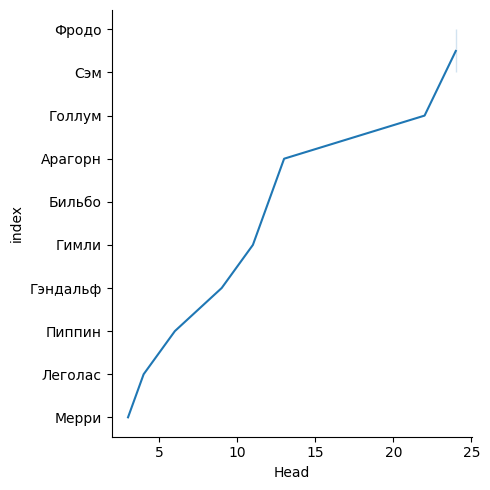

In [104]:
df=pd.read_csv('/content/drive/MyDrive/All  qualities_clean.csv',delimiter=',')

df_counts = df['Head'].value_counts().to_frame()
df_counts = df_counts.reset_index()
df_counts
sns.relplot(data=df_counts, x='Head', y='index', kind="line")

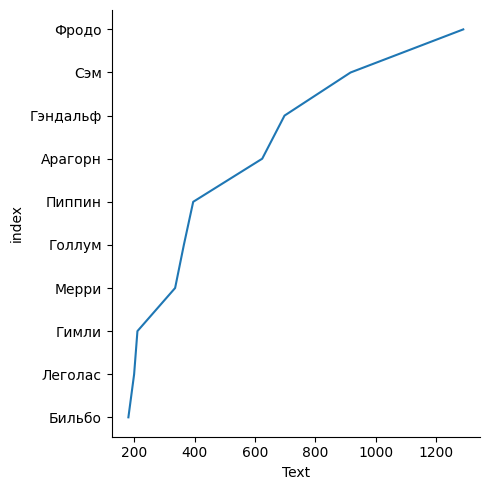

In [31]:
df=pd.read_csv('/content/drive/MyDrive/All actions_clean.csv',delimiter=',')

df_counts = df['Text'].value_counts().to_frame()
df_counts = df_counts.reset_index()
df_counts
sns.relplot(data=df_counts, x='Text', y='index', kind="line")

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Frodo actions_clean.csv',delimiter=',')

df_counts = df['Head'].value_counts().to_frame()
df_counts = df_counts.reset_index()
df_counts
sns.relplot(data=df_counts.head(20), x='Head', y='index', kind="line")

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Sam actions_clean.csv',delimiter=',')

df_counts = df['Head'].value_counts().to_frame()
df_counts = df_counts.reset_index()
df_counts
sns.relplot(data=df_counts.head(20), x='Head', y='index', kind="line")

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Gandalf actions_clean.csv',delimiter=',')

df_counts = df['Head'].value_counts().to_frame()
df_counts = df_counts.reset_index()
df_counts
sns.relplot(data=df_counts.head(20), x='Head', y='index', kind="line")

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Bilbo actions_clean.csv',delimiter=',')

df_counts = df['Head'].value_counts().to_frame()
df_counts = df_counts.reset_index()
df_counts
sns.relplot(data=df_counts.head(20), x='Head', y='index', kind="line")

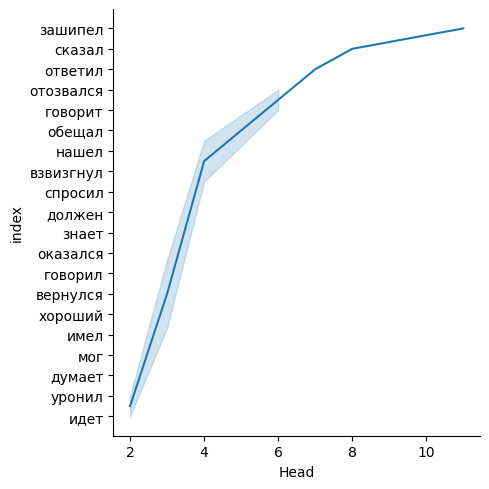

In [56]:
df=pd.read_csv('/content/drive/MyDrive/Gollum actions_clean.csv',delimiter=',')

df_counts = df['Head'].value_counts().to_frame()
df_counts = df_counts.reset_index()
df_counts
sns.relplot(data=df_counts.head(20), x='Head', y='index', kind="line")

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Merry actions_clean.csv',delimiter=',')

df_counts = df['Head'].value_counts().to_frame()
df_counts = df_counts.reset_index()
df_counts
sns.relplot(data=df_counts.head(20), x='Head', y='index', kind="line")

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Pippin actions_clean.csv',delimiter=',')

df_counts = df['Head'].value_counts().to_frame()
df_counts = df_counts.reset_index()
df_counts
sns.relplot(data=df_counts.head(20), x='Head', y='index', kind="line")

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Legolas actions_clean.csv',delimiter=',')

df_counts = df['Head'].value_counts().to_frame()
df_counts = df_counts.reset_index()
df_counts
sns.relplot(data=df_counts.head(20), x='Head', y='index', kind="line")

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Gimli actions_clean.csv',delimiter=',')

df_counts = df['Head'].value_counts().to_frame()
df_counts = df_counts.reset_index()
df_counts
sns.relplot(data=df_counts.head(20), x='Head', y='index', kind="line")